In [1]:
%load_ext autoreload
%autoreload 2

from utils.sampling import stratified_spatial_sampling_dual
from utils.load import *
from data.weather_graph_dataset import WeatherGraphDataset

import torch
from torch_geometric.data import HeteroData
from utils.graphbuilder import GraphBuilder

In [2]:
weather_station_data = load_weather_station_dataset('weather_station_data.csv')
weather_station_locations = get_station_coordinate_mappings()


# Preprocess station data.
Some stations only contain rainfall information but some stations contain both rainfall and other information.
We will split these stations into weather station and general stations 

Additional info: 
  Windspeed
  Wind Direction
  Temperature
  Relative Humidity

In [3]:
cols = list(weather_station_data.columns)
cols.remove('time_sgt')
cols.remove('gid')
weather_station_df_pivot = pd.pivot(data=weather_station_data, index='time_sgt', columns='gid', values=cols).resample('15min').first()
weather_station_df_pivot['rain_rate'] = weather_station_df_pivot['rain_rate'] * 12
weather_station_df_counts = weather_station_df_pivot.count().reset_index()

weather_station_info = pd.pivot(data=weather_station_df_counts, index='gid', columns = 'level_0')

pd.set_option('display.max_rows', None)

rainfall_station = [row[0] for row in weather_station_info.iterrows() if 0 in row[1].value_counts()]
general_station = [s for s in weather_station_locations if s not in rainfall_station]

print(rainfall_station)
print(general_station)

['S07', 'S08', 'S112', 'S113', 'S119', 'S123', 'S201', 'S203', 'S207', 'S208', 'S209', 'S210', 'S211', 'S213', 'S214', 'S215', 'S216', 'S217', 'S218', 'S219', 'S220', 'S221', 'S222', 'S223', 'S224', 'S226', 'S227', 'S228', 'S229', 'S230', 'S24', 'S29', 'S33', 'S40', 'S64', 'S66', 'S69', 'S71', 'S77', 'S78', 'S79', 'S81', 'S84', 'S88', 'S90', 'S900', 'S92', 'S94']
['S109', 'S50', 'S107', 'S43', 'S44', 'S121', 'S106', 'S111', 'S102', 'S60', 'S115', 'S104', 'S117', 'S116', 'S06']


In [4]:
count = 0
for row in weather_station_df_pivot['rain_rate'].iterrows():
  if np.nansum(row[1].to_numpy()) != 0:
    count += 1
print(f"Number of timesteps that contain rain: {count}")


Number of timesteps that contain rain: 1723


In [5]:
pd.set_option('display.max_rows', 20)

general_station_data = {}
rainfall_station_data = {}
for station in weather_station_df_pivot.columns.get_level_values(1).unique():
    station_cols = weather_station_df_pivot.xs(station, level=1, axis=1).interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
    if station in general_station:
      general_station_data[station] = station_cols.values
    else:
      rainfall_station_data[station] = station_cols.values[:, 0:1]

print(rainfall_station_data)

{'S07': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(8736, 1)), 'S08': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(8736, 1)), 'S112': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(8736, 1)), 'S113': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(8736, 1)), 'S119': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(8736, 1)), 'S123': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(8736, 1)), 'S201': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(8736, 1)), 'S203': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(8736, 1)), 'S207': array([[0.],
       [0.],
       [0.],
       ...,
      

/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_24484/3623190968.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_cols = weather_station_df_pivot.xs(station, level=1, axis=1).interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_24484/3623190968.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_cols = weather_station_df_pivot.xs(station, level=1, axis=1).interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_24484/3623190968.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_cols = weather_station_df_pivot.xs(station, 

In [6]:
data = HeteroData()

general_station_features = []
rainfall_station_features = []
for station in general_station:
  station_feat = general_station_data[station]
  general_station_features.append(station_feat)

for station in rainfall_station:
  station_feat = rainfall_station_data[station]
  rainfall_station_features.append(station_feat)

dtype = torch.float32
data['general_station'].x = torch.tensor(np.array(general_station_features).transpose(1, 0, 2), dtype=dtype)
data['rainfall_station'].x = torch.tensor(np.array(rainfall_station_features).transpose(1,0,2), dtype=dtype)

data['general_station'].y = torch.tensor(np.array(general_station_features)[:,:,0:1].transpose(1,0,2), dtype=dtype)
data['rainfall_station'].y = torch.tensor(np.array(rainfall_station_features).transpose(1,0,2), dtype=dtype)

print(data)

HeteroData(
  general_station={
    x=[8736, 15, 5],
    y=[8736, 15, 1],
  },
  rainfall_station={
    x=[8736, 48, 1],
    y=[8736, 48, 1],
  }
)


K-MEANS STRATIFIED SPATIAL SAMPLING
Total stations: 63
Number of clusters: 8
Random seed: 420

Split configuration:
  - Test (shared): 10%
  - Statistical train: 90%
  - ML train: 70%
  - ML validation: 20%

STEP 1: K-means Clustering
Clustering complete. Cluster centers:
  Cluster 0: (103.8899, 1.3238) - 8 stations
  Cluster 1: (103.7211, 1.3533) - 7 stations
  Cluster 2: (103.7878, 1.2850) - 13 stations
  Cluster 3: (103.9656, 1.3530) - 9 stations
  Cluster 4: (103.7632, 1.4335) - 7 stations
  Cluster 5: (103.8348, 1.3373) - 11 stations
  Cluster 6: (103.6487, 1.2749) - 2 stations
  Cluster 7: (103.8745, 1.3967) - 6 stations

STEP 2: Creating Shared Test Set (10%)
  Cluster 0: 8 stations → 1 test, 7 remaining
  Cluster 1: 7 stations → 1 test, 6 remaining
  Cluster 2: 13 stations → 1 test, 12 remaining
  Cluster 3: 9 stations → 1 test, 8 remaining
  Cluster 4: 7 stations → 1 test, 6 remaining
  Cluster 5: 11 stations → 1 test, 10 remaining
  Cluster 6: 2 stations → 0 test, 2 remaining

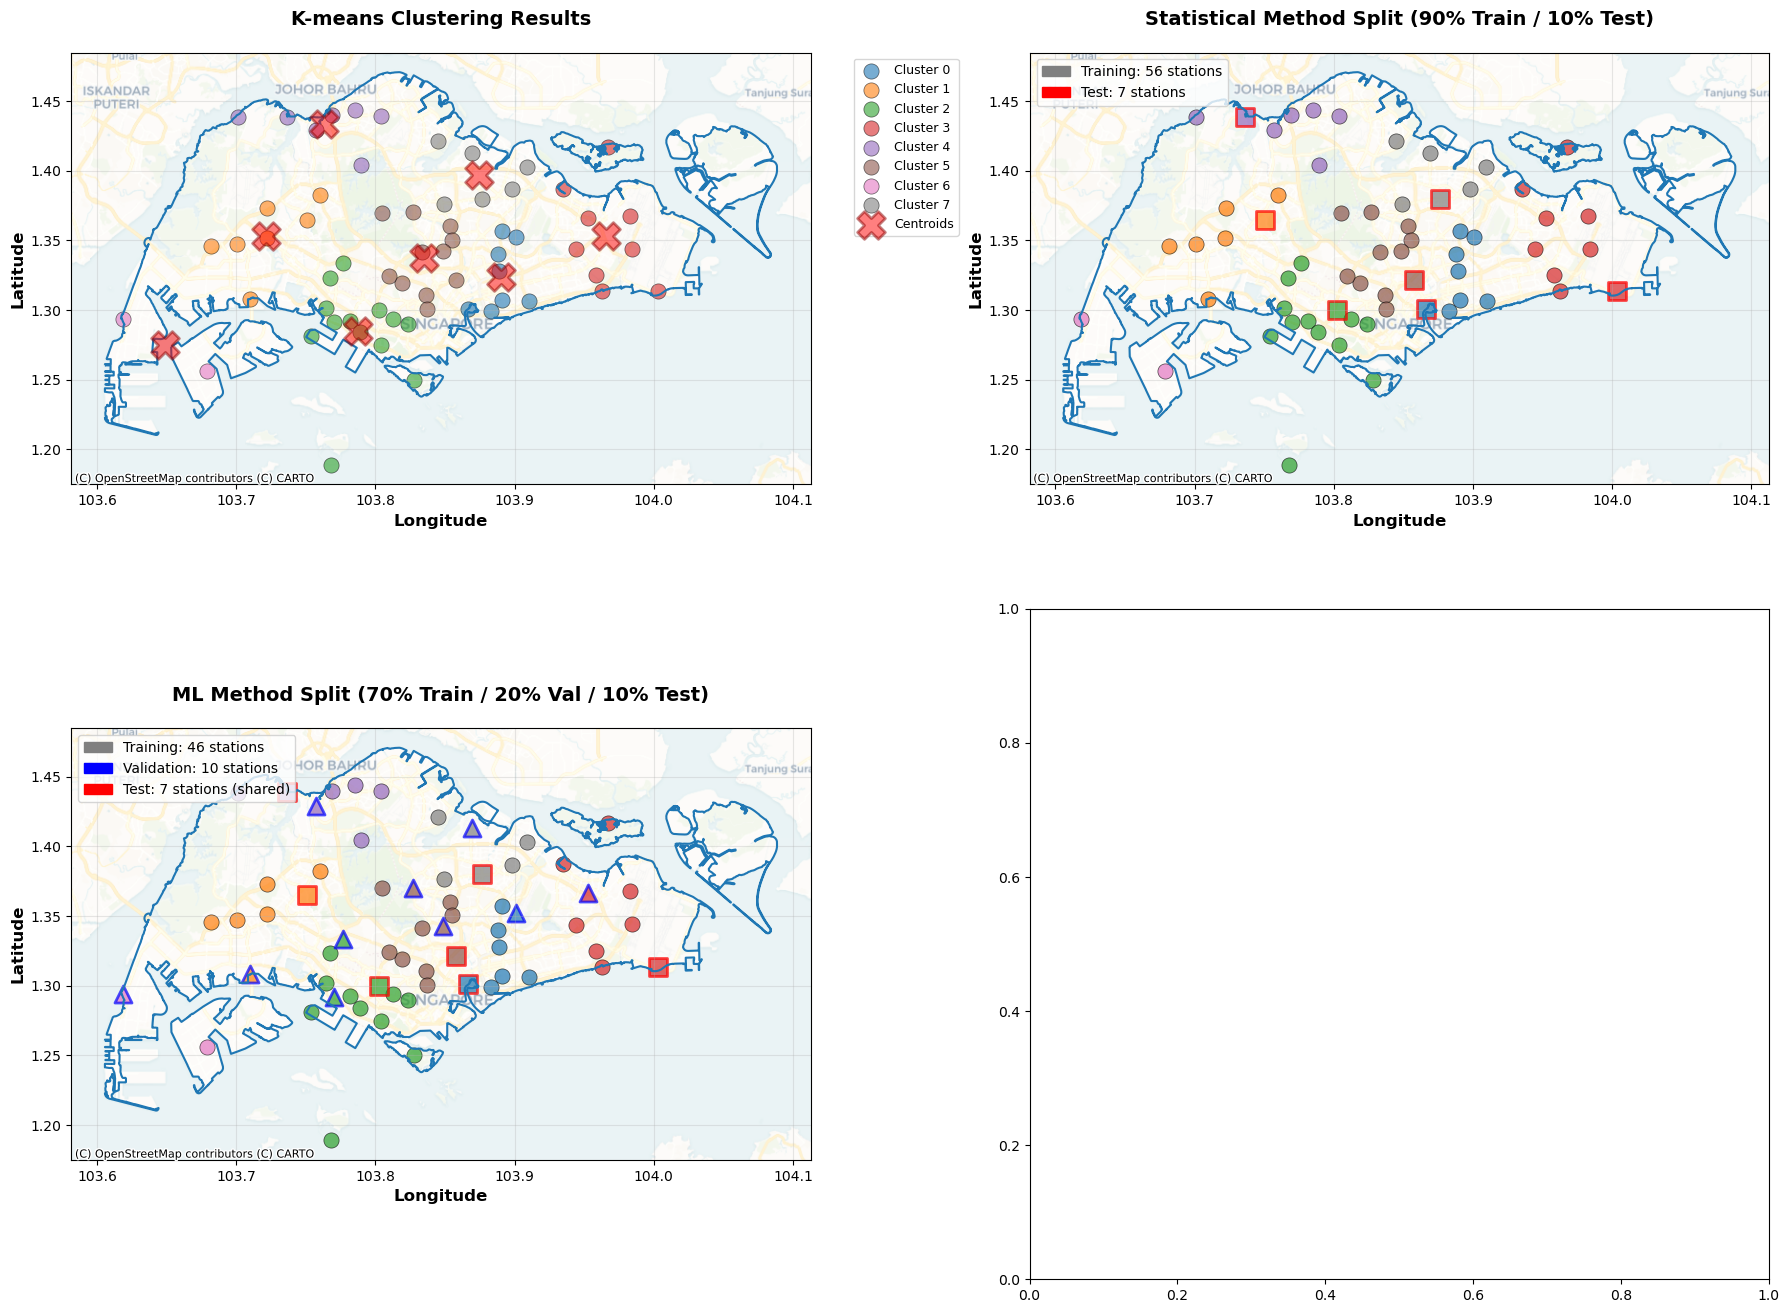

{'statistical': {'train': array(['S214', 'S78', 'S43', 'S06', 'S113', 'S215', 'S221', 'S64', 'S229',
       'S33', 'S228', 'S44', 'S121', 'S222', 'S77', 'S201', 'S50', 'S226',
       'S71', 'S230', 'S60', 'S102', 'S203', 'S116', 'S92', 'S94', 'S106',
       'S24', 'S84', 'S224', 'S107', 'S29', 'S207', 'S227', 'S40', 'S210',
       'S112', 'S104', 'S211', 'S217', 'S69', 'S111', 'S07', 'S79', 'S88',
       'S213', 'S08', 'S216', 'S90', 'S117', 'S115', 'S220', 'S109',
       'S209', 'S900', 'S81'], dtype='<U4'), 'test': array(['S119', 'S218', 'S223', 'S208', 'S66', 'S123', 'S219'], dtype='<U4')}, 'ml': {'train': array(['S221', 'S43', 'S215', 'S214', 'S113', 'S78', 'S64', 'S44', 'S228',
       'S121', 'S229', 'S92', 'S226', 'S201', 'S230', 'S222', 'S60',
       'S116', 'S102', 'S77', 'S71', 'S84', 'S106', 'S24', 'S207', 'S107',
       'S224', 'S29', 'S112', 'S227', 'S104', 'S210', 'S40', 'S79', 'S90',
       'S213', 'S217', 'S07', 'S69', 'S216', 'S111', 'S117', 'S109',
       'S209', 'S220

In [7]:
split_info = stratified_spatial_sampling_dual(weather_station_locations, seed=420)
print(split_info)

data['general_station'].train_mask = [1 if station in split_info['ml']['train'] else 0 for station in general_station]
data['general_station'].val_mask = [1 if station in split_info['ml']['validation'] else 0 for station in general_station]
data['general_station'].test_mask = [1 if (x == 0 and y == 0) else 0 for x,y in zip(data['general_station'].train_mask, data['general_station'].val_mask)]

data['rainfall_station'].train_mask = [1 if station in split_info['ml']['train'] else 0 for station in rainfall_station]
data['rainfall_station'].val_mask = [1 if station in split_info['ml']['validation'] else 0 for station in rainfall_station]
data['rainfall_station'].test_mask = [1 if (x == 0 and y == 0) else 0 for x,y in zip(data['rainfall_station'].train_mask, data['rainfall_station'].val_mask)]

print(data)

# Edge generation
We consider the location of the stations when performing our edge generation. 
General station locations and rainfall station locations will be considered the same and we will make a connection across the nodes if required. This will ensure that we can connect both the layers together in the graph.

In [8]:
import math
def get_distance(a, b):
  return math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2 )

In [9]:
print(weather_station_locations['S224'][0])

1.34392


['S109', 'S50', 'S107', 'S43', 'S44', 'S121', 'S106', 'S111', 'S102', 'S60', 'S115', 'S104', 'S117', 'S116', 'S06', 'S07', 'S08', 'S112', 'S113', 'S119', 'S123', 'S201', 'S203', 'S207', 'S208', 'S209', 'S210', 'S211', 'S213', 'S214', 'S215', 'S216', 'S217', 'S218', 'S219', 'S220', 'S221', 'S222', 'S223', 'S224', 'S226', 'S227', 'S228', 'S229', 'S230', 'S24', 'S29', 'S33', 'S40', 'S64', 'S66', 'S69', 'S71', 'S77', 'S78', 'S79', 'S81', 'S84', 'S88', 'S90', 'S900', 'S92', 'S94']
[[  1.3764  103.8492 ]
 [  1.3337  103.7768 ]
 [  1.3135  103.9625 ]
 [  1.3399  103.8878 ]
 [  1.34583 103.68166]
 [  1.37288 103.72244]
 [  1.4168  103.9673 ]
 [  1.31055 103.8365 ]
 [  1.189   103.768  ]
 [  1.25    103.8279 ]
 [  1.29377 103.61843]
 [  1.44387 103.78538]
 [  1.256   103.679  ]
 [  1.281   103.754  ]
 [  1.3524  103.9007 ]
 [  1.3415  103.8334 ]
 [  1.3701  103.8271 ]
 [  1.43854 103.70131]
 [  1.30648 103.9104 ]
 [  1.30105 103.8666 ]
 [  1.3214  103.8577 ]
 [  1.32311 103.76714]
 [  1.29164 1

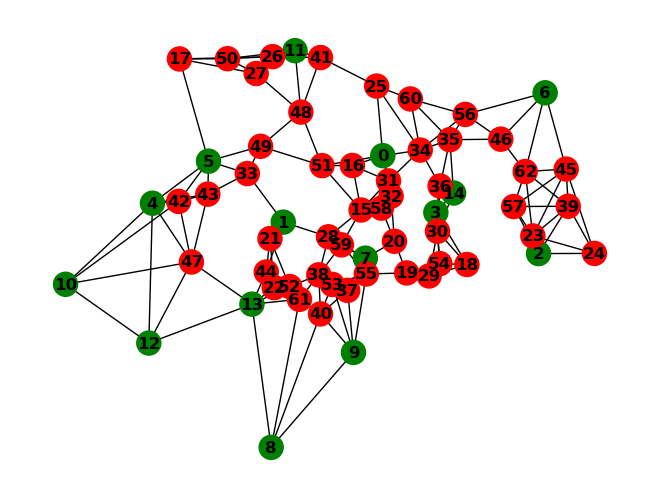

In [10]:
#variable to determine number of neighbours per node
import networkx as nx
from sklearn.neighbors import NearestNeighbors
K = 4

ids = general_station + rainfall_station
print(ids)

coordinates = []
for id in ids:
  coordinates.append(weather_station_locations[id])
coords = np.array(coordinates)

print(coords)
knn = NearestNeighbors(n_neighbors=K+1, algorithm='ball_tree')
knn.fit(coords)

distances, indices = knn.kneighbors(coords)

G = nx.Graph()

edges = {
        'rainfall_to_rainfall': [],  
        'rainfall_to_general': [],    
        'general_to_rainfall': [],  
        'general_to_general': []      
    }

edge_attributes = {
        'rainfall_to_rainfall': [],  
        'rainfall_to_general': [],    
        'general_to_rainfall': [],  
        'general_to_general': []      
}

#add station coordinates for nx plotting
for idx, station in enumerate(general_station + rainfall_station):
  G.add_node(idx, pos=(weather_station_locations[station][1], weather_station_locations[station][0]))
color_map = ['green' for i in range(len(general_station))] + ['red' for i in range(len(rainfall_station))]

for idx, row in enumerate(indices):
  origin = row[0]
  
  for n in row[1:]: 
    G.add_edge(origin, n)
    if ids[origin] in rainfall_station:
      start_id = rainfall_station.index(ids[origin])
      if ids[n] in rainfall_station:
        end_id = rainfall_station.index(ids[n])
        edges['rainfall_to_rainfall'].append([start_id, end_id])
        edge_attributes['rainfall_to_rainfall'].append([get_distance(weather_station_locations[ids[origin]], weather_station_locations[ids[n]])])
      else:
        end_id = general_station.index(ids[n])
        edges['rainfall_to_general'].append([start_id, end_id])
        edge_attributes['rainfall_to_general'].append([get_distance(weather_station_locations[ids[origin]], weather_station_locations[ids[n]])])
    else:
      start_id = general_station.index(ids[origin])
      if ids[n] in rainfall_station:
        end_id = rainfall_station.index(ids[n])
        edges['general_to_rainfall'].append([start_id, end_id])
        edge_attributes['general_to_rainfall'].append([get_distance(weather_station_locations[ids[origin]], weather_station_locations[ids[n]])])
      else:
        end_id = general_station.index(ids[n])
        edges['general_to_general'].append([start_id, end_id])
        edge_attributes['general_to_general'].append([get_distance(weather_station_locations[ids[origin]], weather_station_locations[ids[n]])])

print(G)
print(len(list(nx.connected_components(G))))
nx.draw(G, nx.get_node_attributes(G, 'pos'), node_color = color_map, with_labels=True, font_weight='bold')

for key, val in edges.items():
  xarr = []
  yarr = []
  for x, y in val:
    xarr.append(x)
    yarr.append(y)
  edges[key] = [xarr, yarr]


data['general_station', 'gen_to_rain', 'rainfall_station'].edge_index = torch.tensor(edges['general_to_rainfall'], dtype=torch.int64)
data['rainfall_station', 'rain_to_gen', 'general_station'].edge_index = torch.tensor(edges['rainfall_to_general'], dtype=torch.int64)
data['general_station', 'gen_to_gen', 'general_station'].edge_index = torch.tensor(edges['general_to_general'], dtype=torch.int64)
data['rainfall_station', 'rain_to_rain', 'rainfall_station'].edge_index = torch.tensor(edges['rainfall_to_rainfall'], dtype=torch.int64)

data['general_station', 'gen_to_rain', 'rainfall_station'].edge_attr = torch.tensor(edge_attributes['general_to_rainfall'], dtype=torch.float32)
data['rainfall_station', 'rain_to_gen', 'general_station'].edge_attr = torch.tensor(edge_attributes['rainfall_to_general'], dtype=torch.float32)
data['general_station', 'gen_to_gen', 'general_station'].edge_attr = torch.tensor(edge_attributes['general_to_general'], dtype=torch.float32)
data['rainfall_station', 'rain_to_rain', 'rainfall_station'].edge_attr = torch.tensor(edge_attributes['rainfall_to_rainfall'], dtype=torch.float32)

print(data)

In [11]:
print(len(edge_attributes['rainfall_to_rainfall']))

152


In [12]:
#Process edge indices
print(data)
print(data.edge_types)



HeteroData(
  general_station={
    x=[8736, 15, 5],
    y=[8736, 15, 1],
    train_mask=[15],
    val_mask=[15],
    test_mask=[15],
  },
  rainfall_station={
    x=[8736, 48, 1],
    y=[8736, 48, 1],
    train_mask=[48],
    val_mask=[48],
    test_mask=[48],
  },
  (general_station, gen_to_rain, rainfall_station)={
    edge_index=[2, 50],
    edge_attr=[50, 1],
  },
  (rainfall_station, rain_to_gen, general_station)={
    edge_index=[2, 40],
    edge_attr=[40, 1],
  },
  (general_station, gen_to_gen, general_station)={
    edge_index=[2, 10],
    edge_attr=[10, 1],
  },
  (rainfall_station, rain_to_rain, rainfall_station)={
    edge_index=[2, 152],
    edge_attr=[152, 1],
  }
)
[('general_station', 'gen_to_rain', 'rainfall_station'), ('rainfall_station', 'rain_to_gen', 'general_station'), ('general_station', 'gen_to_gen', 'general_station'), ('rainfall_station', 'rain_to_rain', 'rainfall_station')]


In [13]:
print(data['general_station', 'gen_to_rain', 'rainfall_station'].edge_index) 
print(data['rainfall_station', 'rain_to_gen', 'general_station'].edge_index) 
print(data['general_station', 'gen_to_gen', 'general_station'].edge_index) 
print(len(set(data['rainfall_station', 'rain_to_rain', 'rainfall_station'].edge_index.detach().numpy()[0])) )

tensor([[ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  4,  4,  4,
          5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  9,  9,  9,  9,
         10, 10, 11, 11, 11, 11, 12, 13, 13, 13, 13, 14, 14, 14],
        [16,  1, 17, 19,  6, 13, 29, 18,  8, 42, 24,  9, 15, 21, 39, 27, 28, 32,
         28, 18, 27, 34, 31, 30, 47, 41, 40, 44,  5, 22, 25, 46, 25, 22, 38, 40,
         32, 27, 11, 26, 12, 33, 32,  7, 29, 37, 46, 21, 15, 20]])
tensor([[ 1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 15, 16, 17, 18, 18,
         19, 20, 21, 21, 22, 24, 26, 27, 27, 28, 28, 29, 31, 32, 32, 33, 34, 35,
         36, 40, 42, 44],
        [ 0,  5,  3,  7,  1, 13,  2,  2,  0, 11, 11,  7,  3, 14,  0,  0,  5,  1,
          0, 14, 14,  3,  7,  2, 11,  4,  5,  5,  4, 13,  6,  4, 13, 11,  5, 11,
          0,  7,  2,  7]])
tensor([[ 3,  4,  8,  8, 10, 10, 12, 12, 12, 14],
        [14,  5,  9, 13, 12,  4, 10, 13,  4,  3]])
48


In [14]:
print(data.has_isolated_nodes())
print(data.has_self_loops())
print(data.is_undirected())

True
False
False


In [15]:
print(data['general_station', 'gen_to_rain', 'rainfall_station']['edge_index'])

tensor([[ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  4,  4,  4,
          5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  9,  9,  9,  9,
         10, 10, 11, 11, 11, 11, 12, 13, 13, 13, 13, 14, 14, 14],
        [16,  1, 17, 19,  6, 13, 29, 18,  8, 42, 24,  9, 15, 21, 39, 27, 28, 32,
         28, 18, 27, 34, 31, 30, 47, 41, 40, 44,  5, 22, 25, 46, 25, 22, 38, 40,
         32, 27, 11, 26, 12, 33, 32,  7, 29, 37, 46, 21, 15, 20]])


# Creating the GNN

In [16]:
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, GINEConv, to_hetero, HeteroConv, GCNConv, GATConv, Linear, SimpleConv

class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('general_station', 'gen_to_gen', 'general_station'): SAGEConv((-1, -1), hidden_channels),
                ('general_station', 'gen_to_rain', 'rainfall_station'): SAGEConv((-1, -1), hidden_channels),
                ('rainfall_station', 'rain_to_gen', 'general_station'): SAGEConv((-1, -1), hidden_channels),
                ('rainfall_station', 'rain_to_rain', 'rainfall_station'): SAGEConv((-1, -1), hidden_channels),
            }, aggr='sum')
            self.convs.append(conv)


        self.lin_rainfall = Linear(hidden_channels, out_channels)
        self.lin_general = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: x.relu() for key, x in x_dict.items()}

        gen_out = self.lin_general(x_dict['general_station'])
        rain_out = self.lin_rainfall(x_dict['rainfall_station'])

        return{
            'general_station': gen_out,
            'rainfall_station': rain_out
        }

model = HeteroGNN(hidden_channels=4, out_channels=1,
                  num_layers=2)

model.to(device='cuda' if torch.cuda.is_available() else 'cpu')

HeteroGNN(
  (convs): ModuleList(
    (0-1): 2 x HeteroConv(num_relations=4)
  )
  (lin_rainfall): Linear(4, 1, bias=True)
  (lin_general): Linear(4, 1, bias=True)
)

In [17]:
import tqdm
import torch.nn.functional as F
def collate_temporal_graphs(batch):
  gen_x = torch.stack([item['gen_x'] for item in batch])
  rain_x = torch.stack([item['rain_x'] for item in batch])
  gen_y = torch.stack([item['gen_y'] for item in batch])
  rain_y = torch.stack([item['rain_y'] for item in batch])
  
  return {
      'gen_x': gen_x,
      'rain_x': rain_x,
      'gen_y': gen_y,
      'rain_y': rain_y
  }

def train_epoch(model, data, dataloader, optimizer, device):
  model.train()
  total_training_loss = 0

  train_gen_mask = torch.tensor(data['general_station'].train_mask, dtype=torch.bool).to(device)
  train_rain_mask = torch.tensor(data['rainfall_station'].train_mask, dtype=torch.bool).to(device)

  edge_index_dict = {
    key:val.to(device) for key, val in data.edge_index_dict.items()
  }
  for batch in tqdm.tqdm(dataloader, desc="training"):
    gen_x = batch['gen_x'].to(device)  # [batch_size, num_gen_nodes, gen_features]
    rain_x = batch['rain_x'].to(device)  # [batch_size, num_rain_nodes, rain_features]
    gen_y = batch['gen_y'].to(device)
    rain_y = batch['rain_y'].to(device)

    batch_size = gen_x.shape[0]

    batch_loss = 0
    for i in range(batch_size):

      x_dict = {
        'general_station': gen_x[i],
        'rainfall_station': rain_x[i]
      }
      optimizer.zero_grad()
      out = model(x_dict, edge_index_dict)


      gen_predictions = out['general_station'][train_gen_mask]
      rain_predictions = out['rainfall_station'][train_rain_mask]


      training_loss = F.mse_loss(gen_predictions, gen_y[i][train_gen_mask]) + F.mse_loss(rain_predictions, rain_y[i][train_rain_mask])
      batch_loss += training_loss

    batch_loss = batch_loss / batch_size 
    batch_loss.backward()
    optimizer.step()
    total_training_loss += batch_loss.item()
 
  return total_training_loss/len(dataloader)


In [18]:
def validate(model, data, dataloader, device):
  total_validation_loss = 0

  val_gen_mask = torch.tensor(data['general_station'].val_mask, dtype=torch.bool).to(device)
  val_rain_mask = torch.tensor(data['rainfall_station'].val_mask, dtype=torch.bool).to(device)

  edge_index_dict = {
    key:val.to(device) for key, val in data.edge_index_dict.items()
  }
  for batch in tqdm.tqdm(dataloader, desc="validation"):
    gen_x = batch['gen_x'].to(device)  # [batch_size, num_gen_nodes, gen_features]
    rain_x = batch['rain_x'].to(device)  # [batch_size, num_rain_nodes, rain_features]
    gen_y = batch['gen_y'].to(device)
    rain_y = batch['rain_y'].to(device)

    batch_size = gen_x.shape[0]

    batch_loss = 0
    for i in range(batch_size):

      x_dict = {
        'general_station': gen_x[i],
        'rainfall_station': rain_x[i]
      }
      out = model(x_dict, edge_index_dict)


      gen_predictions = out['general_station'][val_gen_mask]
      rain_predictions = out['rainfall_station'][val_rain_mask]


      validation_loss = F.mse_loss(gen_predictions, gen_y[i][val_gen_mask]) + F.mse_loss(rain_predictions, rain_y[i][val_rain_mask])
      
  
      batch_loss += validation_loss.item()
    total_validation_loss += batch_loss
 
  return total_validation_loss/len(dataloader)

In [19]:
import torch
import torch.nn.functional as F
import random 
import tqdm as tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import time

#set seeds
seed=123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


batch_size=16
train_dataset = WeatherGraphDataset(data, mode='train')
val_dataset = WeatherGraphDataset(data, mode='val')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_loader = DataLoader(
  train_dataset,
  batch_size=batch_size,
  shuffle=False,
  collate_fn=collate_temporal_graphs
)
test_loader = DataLoader(
  val_dataset,
  batch_size=batch_size,
  shuffle=False,
  collate_fn=collate_temporal_graphs
)

optimizer=torch.optim.Adam(model.parameters(), lr=0.005)
training_loss_arr = []
validation_loss_arr = []
early = 0
mini = 1000
stopping_condition = 3
epochs=0

training_start = time.time()
for i in range(20):
  print(f'-----EPOCH: {i + 1}-----')
  train_loss = train_epoch(model, data, train_loader, optimizer, device)
  validation_loss = validate(model, data, test_loader, device)
  training_loss_arr.append(train_loss)
  validation_loss_arr.append(validation_loss)
  if mini >= validation_loss:
    mini = validation_loss
    early = 0
  else:
    early += 1
  epochs+=1
  if early >= stopping_condition:
    print("Early stop loss")
    break

  print(f"Train Loss: {train_loss:.4f}")
  print(f"Validation Loss: {validation_loss:.4f}")

training_end = time.time()

print(f"Training took {training_end - training_start} seconds over {epochs} epochs")
plt.plot(training_loss_arr, label='training_loss', color='blue')
plt.plot(validation_loss_arr, label='validation_loss', color='red')
plt.legend()


-----EPOCH: 1-----


validation: 100%|██████████| 546/546 [00:07<00:00, 73.03it/s]


Train Loss: 11.1455
Validation Loss: 32.7197
-----EPOCH: 2-----


training:  58%|█████▊    | 318/546 [00:06<00:04, 45.82it/s]


KeyboardInterrupt: 

In [ ]:
print(data)

In [ ]:
total_params = sum(param.numel() for param in model.parameters())
print(total_params)
print(list(param for param in model.parameters()))


In [ ]:
from scipy.stats import pearsonr

def test_model():
  model.eval()
  total_rmse = 0

  plot_preds = np.array([])
  plot_actual = np.array([])

  test_dataset = WeatherGraphDataset(data, mode='test')

  gen_mask = torch.tensor(data['general_station'].test_mask, dtype=torch.bool).to(device)
  rain_mask = torch.tensor(data['rainfall_station'].test_mask, dtype=torch.bool).to(device)

  edge_index_dict = {
    key:val.to(device) for key, val in data.edge_index_dict.items()
  }

  dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_temporal_graphs
  )

  count = 0
  with torch.no_grad():
    for batch in tqdm.tqdm(dataloader, desc="testing"):
      gen_x = batch['gen_x'].to(device)  # [batch_size, num_gen_nodes, gen_features]
      rain_x = batch['rain_x'].to(device)  # [batch_size, num_rain_nodes, rain_features]
      gen_y = batch['gen_y'].to(device)
      rain_y = batch['rain_y'].to(device)

      batch_size = gen_x.shape[0]

      batch_rmse = 0
      for i in range(batch_size):

        x_dict = {
          'general_station': gen_x[i],
          'rainfall_station': rain_x[i]
        }

        out = model(x_dict, edge_index_dict)

        gen_predictions = out['general_station'][gen_mask]
        rain_predictions = out['rainfall_station'][rain_mask]

        gen_targets = gen_y[i][gen_mask]
        rain_targets = rain_y[i][rain_mask]

        plot_preds = np.concatenate((plot_preds, gen_predictions.detach().numpy().flatten(), rain_predictions.detach().numpy().flatten()))
        plot_actual = np.concatenate((plot_actual, gen_targets.detach().numpy().flatten(), rain_targets.detach().numpy().flatten()))

        gen_MSE_arr = (gen_predictions - gen_targets) ** 2
        rain_MSE_arr = (rain_predictions - rain_targets) ** 2

        all_squared_errors = torch.cat([gen_MSE_arr, rain_MSE_arr])
        test_rmse = torch.sqrt(torch.mean(all_squared_errors))

        batch_rmse += test_rmse.item()
        count += 1

      total_rmse += batch_rmse
 
  plt.scatter(x=plot_actual, y=plot_preds)
  plot_bound = max(np.nanmax(plot_actual).astype(int),np.nanmax(plot_preds).astype(int))
  plt.plot(np.linspace(0,plot_bound,100),
            np.linspace(0,plot_bound,100))
  plt.xlabel("actual rainfall")
  plt.ylabel("predicted rainfall")

  mask = ~np.isnan(plot_actual)
  pearson_r_global, pearson_p_global = pearsonr(plot_actual[mask], plot_preds[mask])

  print(f"Pearson correlation: {pearson_r_global}")
  return total_rmse/count

In [ ]:
print(data.has_isolated_nodes())
print(data.has_self_loops())

In [ ]:
RMSE = test_model()
print(f"TEST RMSE: {RMSE}")

# Visualisation of output
Test event will be 02-05-2025 0415 to 0615


In [ ]:
test_event_data = weather_station_df_pivot.iloc[593:602]
print(test_event_data)
test_data = data.clone()

test_general_station_data = {}
test_rainfall_station_data = {}

for station in test_event_data.columns.get_level_values(1).unique():
    station_cols = test_event_data.xs(station, level=1, axis=1).interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
    if station in general_station:
      test_general_station_data[station] = station_cols.values 
    else:
      test_rainfall_station_data[station] = station_cols.values[:, 0:1]
# print(test_general_station_data)
# print(test_rainfall_station_data)

test_general_station_features = []
test_rainfall_station_features = []

for station in general_station:
  if station in test_general_station_data:
    station_feat = test_general_station_data[station]
    test_general_station_features.append(station_feat)

for station in rainfall_station:
  if station in test_rainfall_station_data:
    station_feat = test_rainfall_station_data[station]
    test_rainfall_station_features.append(station_feat)

# print(test_general_station_features)
# print(test_rainfall_station_features)

test_data['general_station'].x = torch.tensor(np.array(test_general_station_features).transpose(1,0,2), dtype=torch.float)
test_data['general_station'].y = torch.tensor(np.array(test_general_station_features)[:, :,0:1].transpose(1,0,2), dtype=torch.float)
test_data['rainfall_station'].x = torch.tensor(np.array(test_rainfall_station_features).transpose(1,0,2), dtype=torch.float) 
test_data['rainfall_station'].y = torch.tensor(np.array(test_rainfall_station_features).transpose(1,0,2), dtype=torch.float)  

out = model(test_data.x_dict, test_data.edge_index_dict)
gen_out = out['general_station'].detach().numpy()
rain_out = out['rainfall_station'].detach().numpy()

out_np = np.concatenate([gen_out, rain_out], axis=1)

In [ ]:
print(test_data.edge_index_dict)

# Visualise rain on radar grid
Hard coded to plot only consequitive 9 timestamps

In [ ]:
print(out_np / 12)

In [ ]:
from utils.load import *
from utils.visualisation import *
radar_df = load_radar_dataset('radar_vis')

fig, ax = plt.subplots(3,3, figsize=(15,12), subplot_kw={'projection' : ccrs.PlateCarree()})

bounds_singapore = {
  'left': 103.6,
  'right': 104.1,
  'top': 1.5,
  'bottom': 1.188
}
bounds = [0.1, 0.2, 0.5, 1, 2, 4, 7, 10, 20] 
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

out_np = out_np / 12
for idx, timestamp in enumerate(out_np):
  output = {}
  count = 0
  
  for stn in general_station:
    output[stn] = float(timestamp[count])
    count += 1
  for stn in rainfall_station:
    output[stn] = float(timestamp[count])
    count += 1
  axi = ax[idx // 3][idx % 3]
  node_df = pd.Series(output)
  node_df = pandas_to_geodataframe(node_df)
  visualise_gauge_grid(node_df=node_df, ax=axi)
  improved_visualise_radar_grid(radar_df.iloc[idx], ax=axi, zoom=bounds_singapore, norm=norm)
  visualise_singapore_outline(ax=axi)

In [ ]:
original_rainfall_rates = weather_station_df_pivot.iloc[1773:1797].resample('15min').first()['rain_rate']


print(original_rainfall_rates)

In [ ]:
print(out)

In [ ]:
actual_arr = []
pred_arr = []

for idx, timestamp in enumerate(out):
  output = {}
  count = 0
  a_arr = []
  p_arr = []
  
  for stn in general_station:
    output[stn] = float(timestamp[count])
    count += 1
  for stn in rainfall_station:
    output[stn] = float(timestamp[count])
    count += 1

  for key, value in output.items():
    a_arr.append(original_rainfall_rates.iloc[idx][key])
    p_arr.append(output[key])
  a_arr = list(map(lambda x: float(x), a_arr))
  actual_arr.append(a_arr)
  pred_arr.append(p_arr)

actual_arr = np.array(actual_arr)
pred_arr = np.array(pred_arr)

print(actual_arr)
print(pred_arr)
error = []
for i in range(len(actual_arr)):
  error.append(np.nanmean(actual_arr - pred_arr) ** 2)

MSE = np.mean(np.array(error))
print(MSE)


In [ ]:
print(original_rainfall_rates.iloc[0])